In [1]:
from ybco import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from scipy.io import savemat
import numpy as np

In [2]:
%%time

# Redefine bin boundaries
# bin_boundaries = np.arange(-10, 30, 0.1)
bin_boundaries = np.arange(5, 30, 0.2)
hist_start_bin = 1

# Define parameters
roi_x_start, roi_x_end = 50, 100
roi_y_start, roi_y_end = 0, 200
roi_coordinates = (roi_x_start, roi_x_end, roi_y_start, roi_y_end)

# Define your parameters for CDW_PP
# IPM_pos_Filter, Time_bin, TimeTool = [0.2,0.5],1.,[1.,0.005]
IPM_pos_Filter, Time_bin, TimeTool = [0.2,0.5], 2, [0.,0.005]

Run_Number = 195
ROI = [5,105,50,250]
Energy_Filter = [8.8,5]
I0_Threshold = 200

#from lcls.pvalues import compute_aggregate_pvals
from pvalues import compute_aggregate_pvals
from typing import Dict, List, Tuple, Any

CPU times: user 182 ms, sys: 64.5 ms, total: 247 ms
Wall time: 421 ms


In [10]:
Energy_Filter

[8.8, 5]

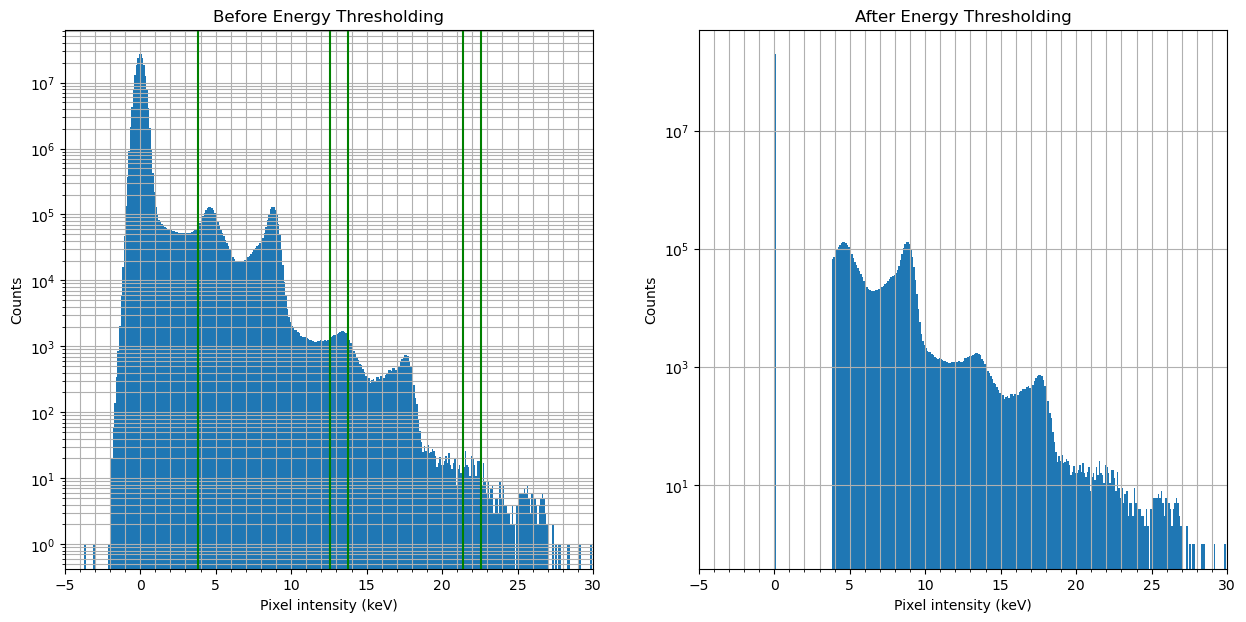

CPU times: user 26.6 s, sys: 23.7 s, total: 50.3 s
Wall time: 1min 28s


In [3]:
%%time

from pump_probe import CDW_PP

cdw_output = CDW_PP(Run_Number, ROI,
                    Energy_Filter, I0_Threshold,
                    IPM_pos_Filter, Time_bin, TimeTool)

from typing import List, Dict

def combine_stacks(stacks: List[Dict[float, np.ndarray]]) -> np.ndarray:
    """
    Combines multiple stacks into a single 3D numpy array by concatenating the 3D arrays from each stack.

    Parameters:
        stacks (List[Dict[float, np.ndarray]]): A list of stacks, where each stack is a dictionary mapping time delays to 3D numpy arrays.

    Returns:
        np.ndarray: A single 3D numpy array obtained by stacking the 3D arrays from all provided stacks.
    """
    # Extract all 3D arrays from each stack and concatenate them
    combined_array = np.concatenate([array for stack in stacks for array in stack.values()], axis=0)

    return combined_array

imgs_thresh = combine_stacks([cdw_output['stacks_off']])

In [4]:
%%time

# %run histogram_analysis.py
from lcls.histogram_analysis import *

from scipy.stats import wasserstein_distance
from scipy.ndimage import label

data = imgs_thresh#[:7000, ...]#load_data(filepath)
histograms = calculate_histograms(data, bin_boundaries, hist_start_bin)

threshold = .1
# Run the analysis
res = run_histogram_analysis(
    bin_boundaries = bin_boundaries, hist_start_bin = hist_start_bin,
    roi_x_start = roi_x_start, roi_x_end = roi_x_end, roi_y_start = roi_y_start,
    roi_y_end = roi_y_end, data = data,
    threshold = threshold)
signal_mask = res['signal_mask']

CPU times: user 36.8 s, sys: 3.02 s, total: 39.8 s
Wall time: 40.2 s


In [5]:
import histogram_analysis

In [6]:
import pump_probe
from importlib import reload
reload(pump_probe)

<module 'pump_probe' from '/sdf/data/lcls/ds/xpp/xppx1003221/results/ohoidn/Shift 4/pump_probe.py'>

## Human CDW analysis

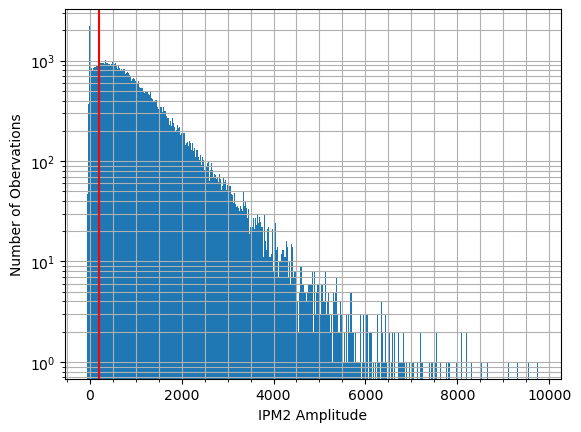

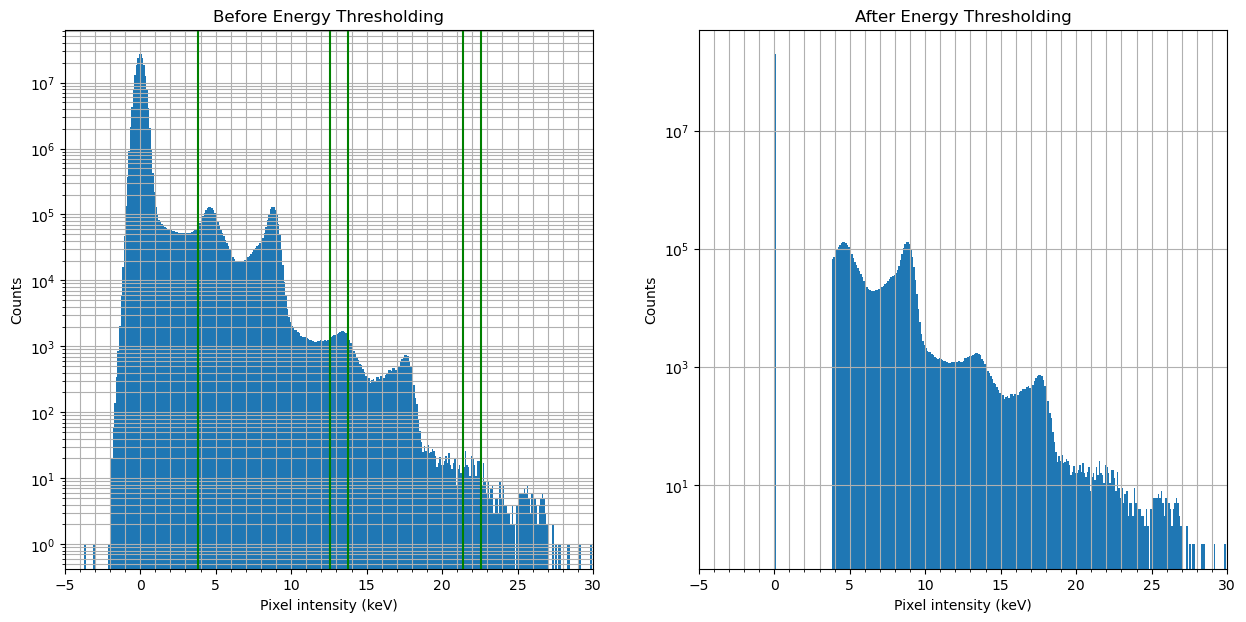

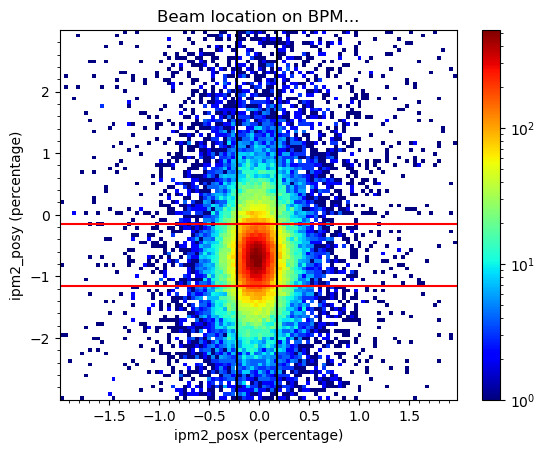

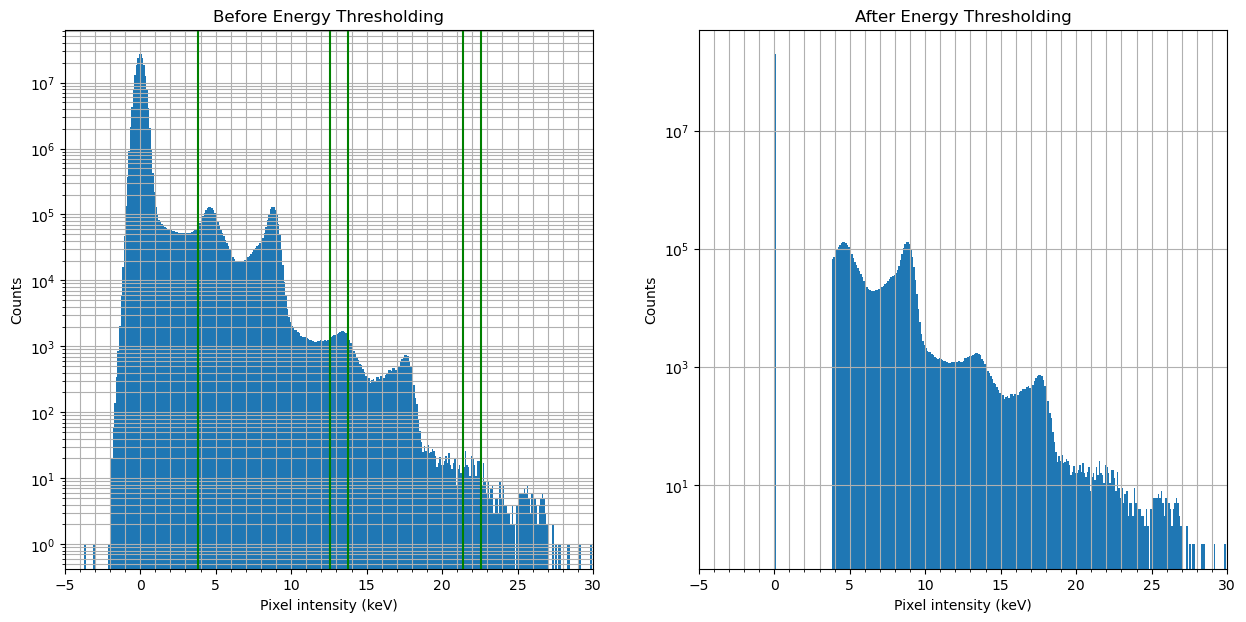

Working on the data of delay 24.00 ps...
Number of laser on and off events after filtering are 1080/869.
Working on the data of delay 26.00 ps...
Number of laser on and off events after filtering are 1677/1310.
Working on the data of delay 28.00 ps...
Number of laser on and off events after filtering are 1653/1335.
Working on the data of delay 30.00 ps...
Number of laser on and off events after filtering are 1648/1354.
Working on the data of delay 32.00 ps...
Number of laser on and off events after filtering are 1634/1293.
Working on the data of delay 34.00 ps...
Number of laser on and off events after filtering are 1663/1277.
Working on the data of delay 36.00 ps...
Number of laser on and off events after filtering are 1650/1294.
Working on the data of delay 38.00 ps...
Number of laser on and off events after filtering are 1629/1287.
Working on the data of delay 40.00 ps...
Number of laser on and off events after filtering are 1603/1342.
Working on the data of delay 42.00 ps...
Number

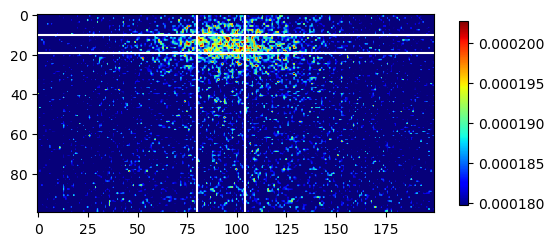

In [7]:
import ybco

aimg,simg = ybco.CDW_Optimizer(Run_Number, ROI, Energy_Filter, I0_Threshold)
delay,imgs_on,imgs_off  = ybco.CDW_PP(Run_Number, ROI, Energy_Filter, I0_Threshold, IPM_pos_Filter, Time_bin,TimeTool)
row1,row2,col1,col2 = 10,20,80,105  # boundaries of the ROI
mask = ybco.mask_go(aimg,row1,row2,col1,col2)

pp_lazy_data = pump_probe.generate_pp_lazy_data(imgs_on, imgs_off, mask, delay, False)

## Automated CDW analysis

### signal / background mask visualization

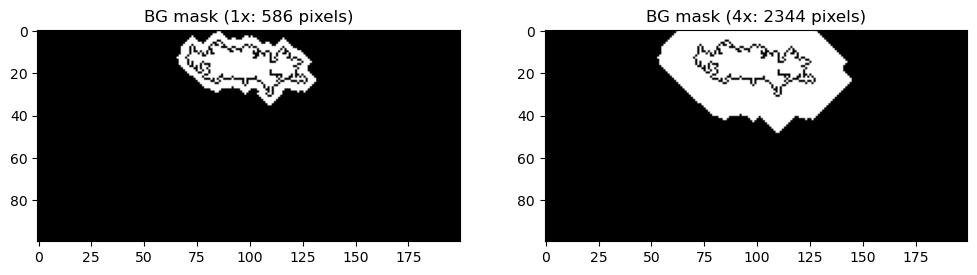

(586, (100, 200), (100, 200))

In [8]:
# Counting the number of True pixels in the signal mask
true_pixels_count = np.sum(signal_mask)

# Test values for num_pixels
num_pixels_exact = true_pixels_count
num_pixels_double = 4 * true_pixels_count

# Running the create_continuous_buffer function with these test values
continuous_buffer_exact = histogram_analysis.create_continuous_buffer(signal_mask, num_pixels = num_pixels_exact)
continuous_buffer_double = histogram_analysis.create_continuous_buffer(signal_mask, num_pixels = num_pixels_double)

# Visualizing the results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the result with exact number of pixels
axes[0].imshow(continuous_buffer_exact | signal_mask, cmap='gray')
axes[0].set_title(f'BG mask (1x: {num_pixels_exact} pixels)')

# Plotting the result with double the number of pixels
axes[1].imshow(continuous_buffer_double | signal_mask, cmap='gray')
axes[1].set_title(f'BG mask (4x: {num_pixels_double} pixels)')

plt.show()

true_pixels_count, continuous_buffer_exact.shape, continuous_buffer_double.shape

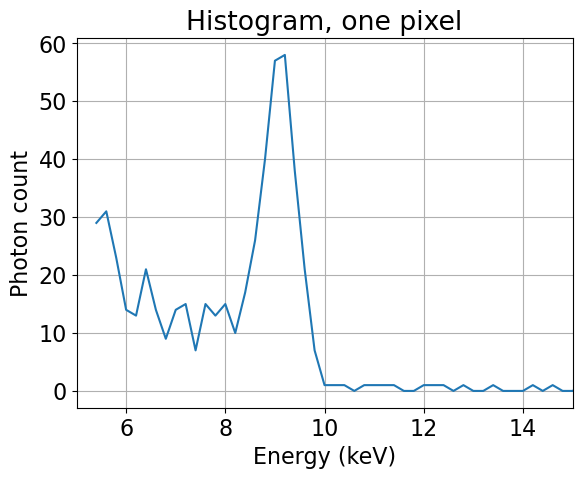

In [13]:
import matplotlib.pyplot as plt
energies = bin_boundaries[hist_start_bin + 1:]

# Increase font size for labels and tick labels
plt.rcParams.update({'font.size': 16})  # You can adjust the font size as needed

plt.plot(energies, histograms[:, 50, 50])
plt.xlabel('Energy (keV)')
plt.ylabel('Photon count')
plt.title('Histogram, one pixel')
plt.xlim((5, 15))
plt.grid()

plt.show()


### pump probe curves

TODOs

right now second-pass energy filtering is hard-coded to 8-10 keV. it should be parameterized.

second-pass energy filtering. For efficiency, energy filtering should operate on the histogram level, not on raw frames.

the first-pass histogram calculation is redundant right now

due to stochasticity of the signal mask definition, the threshold parameter should be optimized in the first pass, and the background area should be optimized in the second pass

In [9]:
%%time
reload(pump_probe)
# Set random seed so that we get the same signal mask when rerunning the notebook. Ultimately,
# we would want to pick some sort of reproducible 'majority vote' mask based on many runs with
# different seeds
np.random.seed(2)
signal_mask = pump_probe.compute_signal_mask(bin_boundaries, hist_start_bin, roi_coordinates, .2, histograms = histograms)

cdw_data = pump_probe.generate_plot_data(cdw_output, signal_mask, bin_boundaries,
                              hist_start_bin, roi_coordinates, 4)

CPU times: user 52 s, sys: 7.03 s, total: 59.1 s
Wall time: 59.3 s


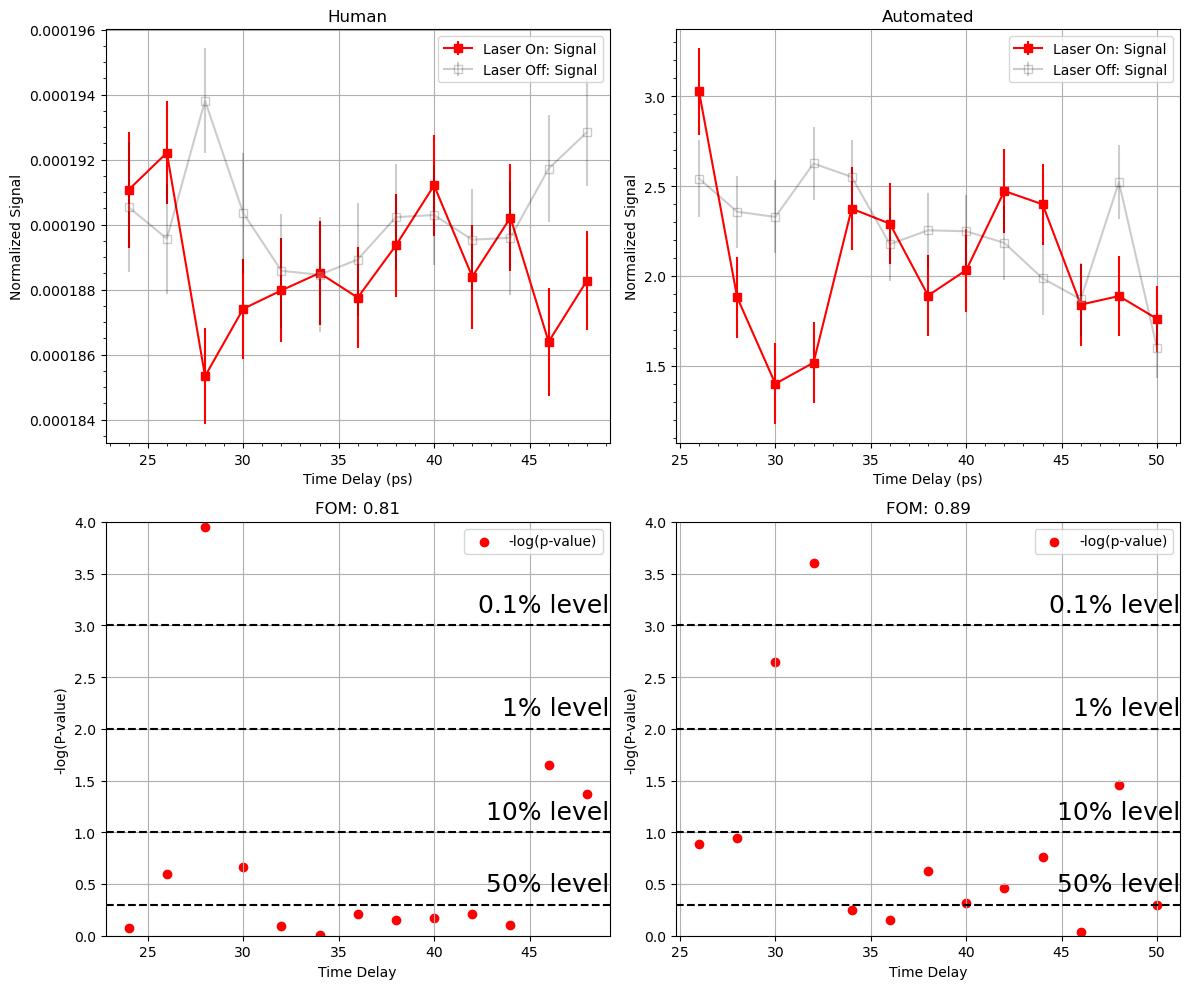

In [32]:
pump_probe.combine_plots(pp_lazy_data, cdw_data)